# Optimizing the model
At this stage of the assignment, finding the optimal model architecture with necessary hyper-parameters is aimed. For easy testing, GPU utilization is performed.
## Necessary Imports
As the necessary imports, the model template implemented and the data utilities are imported. To fasten up the testing process, data compression into a **h5** file is implenented and used.

In [1]:
import tensorflow as tf
from data.data_utils import Dataset, save_dataset
import os
from model import AgeModel
import tensorflow.keras.losses as losses

# Set following config to resolve GPU errors
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()
print("Tensorflow version used: {}".format(tf.__version__))

Tensorflow version used: 2.3.0


## Hardware utilization
The utilization of the GPU effects the training time significantly for this assignment. To ensure that this implementation uses GPU, as an initial stage the presence of the GPU is checked. Even though it is not stated in the assignment that this utilization is not compulsory, it is performed for faster model evaluation.

In [2]:
from tensorflow.python.client import device_lib
def check_if_gpu_used():
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    if len(gpu_names) >= 1:
        print("Number of GPUs used by Tensorflow: {}".format(len(gpu_names)))
    else:
        print("Tensorflow operates on CPU now.")
check_if_gpu_used()

Number of GPUs used by Tensorflow: 1


## Importing the dataset
The dataset given for the assignment is modeled with **Dataset** class. The importing process is as follows.

In [3]:
import h5py
import numpy as np
from time import time
data_path = os.path.join(os.getcwd(), 'data')
datafile_path = os.path.join(data_path, "dataset.h5")
#save_dataset(data_path, dataset) # Compressing data in h5 format
start = time()
f = h5py.File(datafile_path, "r")
train_samples = np.array(f["train_samples"])
train_labels = np.array(f["train_labels"])
val_samples = np.array(f["val_samples"])
val_labels = np.array(f["val_labels"])
test_samples = np.array(f["test_samples"])
test_labels = np.array(f["test_labels"])
end = time()
f.close()
print("Monitoring compressed data details")
## Training set
print("Training data shape: {}".format(train_samples.shape))
print("Training labels shape: {}".format(train_labels.shape))
## Validation set
print("Validation data shape: {}".format(val_samples.shape))
print("Validation labels shape: {}".format(val_labels.shape))
## Test set
print("Testing data shape: {}".format(test_samples.shape))
print("Testing labels shape: {}".format(test_labels.shape))
print("Time to construct the dataset from compressed file: {:.3f} seconds".format(end - start))

Monitoring compressed data details
Training data shape: (5400, 91, 91, 1)
Training labels shape: (5400,)
Validation data shape: (2315, 91, 91, 1)
Validation labels shape: (2315,)
Testing data shape: (1159, 91, 91, 1)
Testing labels shape: (1159,)
Time to construct the dataset from compressed file: 0.159 seconds


## Initial non-regularized model and checking the power of it
For our initial model, we benefited from the architecture proposed for VGG-16 and formed a similar model to it. To see whether it is powerful enough, we trained it on a small amount of data. In this task, we specified the amount of data as 20 samples.

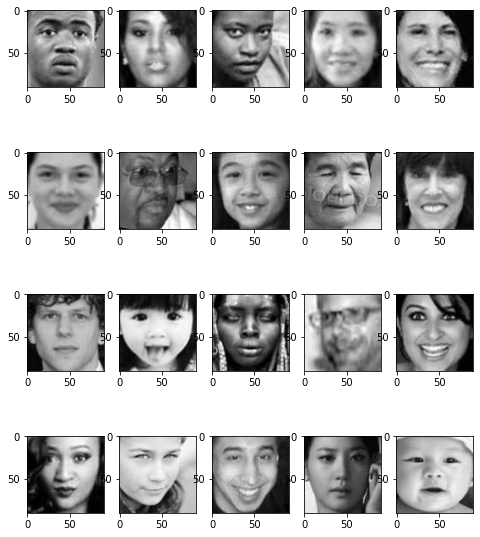

In [4]:
# Generate random data indexes
import matplotlib.pyplot as plt
random_idx = np.random.permutation(train_samples.shape[0])
random_train_samples = train_samples[random_idx[:20]]
random_train_labels = train_labels[random_idx[:20]]
fig, axes = plt.subplots(4,5, figsize=(8,10))
for img_idx in range(random_train_samples.shape[0]):
    row = img_idx // 5
    col = img_idx % 5
    axes[row, col].imshow(random_train_samples[img_idx], cmap="gray")

In [5]:
# Model specification
non_regularized_model = []
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None,"reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 256, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 512, "kernel_size": (1,1), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "flatten"})
non_regularized_model.append({"type": "dense", "units": 256, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 128, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 64, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 1, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})

In [6]:
# Building the model
model_to_overfit = AgeModel(non_regularized_model, "channels_last")
model_to_overfit.build_comp_graph((None, 91, 91, 1)) # Building computational graph to monitor dimensions of layer matrices
model_to_overfit.summary()

Model: "age_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 89, 89, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 39, 39, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 128)       73

Loss for the non-regularized model after 2000 epochs: 0.6408286094665527
Minimum loss value achieved: 0.08625437319278717


Text(0.5, 1.0, 'Loss plot for the non-regularized model')

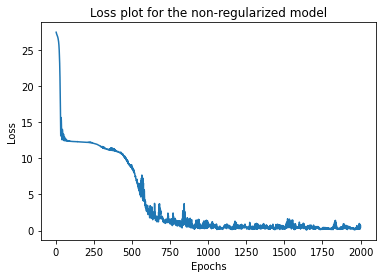

In [7]:
# Compile and run the model
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanAbsoluteError()
model_to_overfit.compile(loss=loss, optimizer=optim)
history = model_to_overfit.fit(x=random_train_samples, y=random_train_labels, epochs=2000, verbose=0)
losses = history.history["loss"]
print("Loss for the non-regularized model after 2000 epochs: {}".format(losses[-1]))
print("Minimum loss value achieved: {}".format(np.amin(losses)))
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot for the non-regularized model")

## Searching for optimal learning rate and regularization
Given the model for testing whteher the model complexity is enough, a coarse search is performed to find the optimal regularization and learning rate values. The initial model architecture is selected considering the previous stage. The function **get_model_with_ratio** is given for constructing model metadata with a given regularization parameter. Here the initial choice for a regularization is selected as L2. In this step the learning rate and regularization parameter is optimized on the training set (w.r.t. validation loss) by performing simple trainings (5 epochs).

In [8]:
def get_model_with_reg(template_model, reg_ratio):
    reg_model = template_model.copy()
    for layer in template_model:
        if layer["type"] in ("dense", "conv2d"):
            layer["regularizer"] = "l2"
            layer["reg_ratio"] = reg_ratio
    return reg_model

In [32]:
from tqdm import tqdm
def optimize_lr_reg(step_count, template_model, training_samples, training_labels, valid_samples, valid_labels):
    lr_exp = np.random.uniform(-6, -3, step_count)
    reg_exp = np.random.uniform(-4, 1, step_count)
    results = []
    # Results stored as (val_loss, train_loss, lr, reg_ratio)
    for exp_idx in tqdm(range(step_count)):
        model_metadata = get_model_with_reg(template_model, 10**reg_exp[exp_idx])
        exp_model = AgeModel(model_metadata, "channels_last")
        exp_model.build_comp_graph((None, 91, 91, 1))
        optim = tf.keras.optimizers.Adam(learning_rate=10**lr_exp[exp_idx])
        loss = tf.keras.losses.MeanAbsoluteError()
        exp_model.compile(loss=loss, optimizer=optim)
        history = exp_model.fit(x=training_samples, y=training_labels, epochs=5, verbose=0, validation_data=(valid_samples, valid_labels))
        results.append((history.history["val_loss"][-1], history.history["loss"][-1], lr_exp[exp_idx], reg_exp[exp_idx]))
    results.sort(key=lambda x: x[0])
    return results
exp_results = optimize_lr_reg(100, non_regularized_model, train_samples[random_idx[:500]], train_labels[random_idx[:500]], val_samples, val_labels)
# Best 10 results - by validation loss
print(exp_results[:10])

100%|██████████| 100/100 [22:25<00:00, 13.45s/it]

[(27.476438522338867, 11.28000545501709, -3.2119391589644954, -3.4032626390691734), (28.615020751953125, 9.69759750366211, -3.454987266365933, -3.543147697187698), (29.0196475982666, 11.653188705444336, -4.182554451268386, -3.485497230848301), (29.443180084228516, 15.329849243164062, -4.471454229252923, -3.149470954538463), (29.542673110961914, 19.837682723999023, -4.842296283346841, -3.9439246280784914), (29.869985580444336, 15.057328224182129, -4.5173084643284955, -3.1822873258716893), (29.945093154907227, 13.682973861694336, -4.395361209868711, -3.2535344405859288), (30.036760330200195, 12.525006294250488, -4.259937548202567, -3.943066220528121), (30.227773666381836, 29.105409622192383, -5.482569210583636, -3.827258857147548), (30.417156219482422, 9.065251350402832, -3.636453893129759, -3.905831308590666)]


After performign the initial experiment, the optimal learning rate is guessed to be around $10^{-3}$ and $10^{-4}$ where the optimal regularization would be in between $10^{-3}$ and $10^{-4}$. In order to get more detail about this issue, a second stage is performed with smaller ranges

In [34]:
def lr_reg_small_range(step_count, template_model, training_samples, training_labels, valid_samples, valid_labels):
    lr_exp = np.random.uniform(-4.5, -2.5, step_count)
    reg_exp = np.random.uniform(-4.5, -2.5, step_count)
    results = []
    # Results stored as (val_loss, train_loss, lr, reg_ratio)
    for exp_idx in tqdm(range(step_count)):
        model_metadata = get_model_with_reg(template_model, 10**reg_exp[exp_idx])
        exp_model = AgeModel(model_metadata, "channels_last")
        exp_model.build_comp_graph((None, 91, 91, 1))
        optim = tf.keras.optimizers.Adam(learning_rate=10**lr_exp[exp_idx])
        loss = tf.keras.losses.MeanAbsoluteError()
        exp_model.compile(loss=loss, optimizer=optim)
        history = exp_model.fit(x=training_samples, y=training_labels, epochs=5, verbose=0, validation_data=(valid_samples, valid_labels))
        results.append((history.history["val_loss"][-1], history.history["loss"][-1], lr_exp[exp_idx], reg_exp[exp_idx]))
    results.sort(key=lambda x: x[0])
    return results
exp_results_2 = lr_reg_small_range(20, non_regularized_model, train_samples[random_idx[:500]], train_labels[random_idx[:500]], val_samples, val_labels)
# Best 10 results - by validation loss
print(exp_results_2[:10])

100%|██████████| 20/20 [04:27<00:00, 13.40s/it]

[(17.102169036865234, 13.037735939025879, -2.6755906215521517, -4.460221967846919), (20.7202205657959, 12.702305793762207, -2.8158488612347607, -3.1343864595493356), (23.580425262451172, 15.587075233459473, -2.683928326693297, -2.912625364209574), (23.907644271850586, 14.937055587768555, -2.5142274395968047, -2.8273766084343626), (27.913774490356445, 10.506239891052246, -3.5058844092599264, -3.2466572281106147), (28.273338317871094, 10.232038497924805, -3.6246189501430814, -3.7107922299673075), (29.07794189453125, 8.345029830932617, -3.558073069945501, -3.491957346277654), (29.25956153869629, 13.753074645996094, -4.495443111408241, -3.988913191590477), (29.764001846313477, 13.0311918258667, -4.420329136470267, -3.9451561109139544), (29.957340240478516, 10.42979907989502, -3.809991752441297, -4.340523925622191)]


Considering our findings, we determined the regularization ratio to be $10^{-3}$ and learning rate to be $10^{-4}$, which is the approximation of the 10 most successful experiments with respect to the validation set loss.

## Adding Batch Normalization
To add batch normalization to our model, we considered four different alternatives. These alternatives are based on the models present in the literature and existing practical work found as open-source. Different alternatives mentioned are mentioned as follows:
- Using batch normalization at every convolutional layer, before activation
- Using batch normalization at every dense layer, before activation
- Combination of first two options
- Using batch normalization after every convolution block, before pooling operation
These experiments are conducted on the whole training dataset and evaluated based on validation set loss. Each of the experiments are performed on different cells and trained for 200 epochs.

In [9]:
def visualize_experiment(history):
    losses = history.history["loss"]
    valid_losses = history.history["val_loss"]
    print("Validation loss for experiment: {}".format(losses[-1]))
    print("Minimum validation loss value achieved: {}".format(np.amin(valid_losses)))
    plt.plot(range(1, len(losses) + 1), losses, color="blue", label="Training Loss")
    plt.plot(range(1, len(losses) + 1), valid_losses, color="orange", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss plot for the non-regularized model")
    plt.legend(loc="upper left")

In [10]:
# Option 1: Using batch normalization at every convolution layer
def batchnorm_opt_1(template_model, reg_ratio, lr, training_samples, training_labels, valid_samples, valid_labels):
    batchnorm_model = template_model.copy()
    # batchnorm_model = get_model_with_reg(template_model, reg_ratio)
    for layer in batchnorm_model:
        if layer["type"] == "conv2d":
            layer["batch_norm"] = True
    exp_model = AgeModel(batchnorm_model, "channels_last")
    exp_model.build_comp_graph((None, 91, 91, 1))
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanAbsoluteError()
    exp_model.compile(loss=loss, optimizer=optim)
    history = exp_model.fit(x=training_samples, y=training_labels, epochs=100, verbose=1, validation_data=(valid_samples, valid_labels))
    return history

Epoch 1/100
169/169 [==============================] - 12s 68ms/step - loss: 13.8806 - val_loss: 27.5932
Epoch 2/100
169/169 [==============================] - 11s 67ms/step - loss: 8.9484 - val_loss: 17.6550
Epoch 3/100
169/169 [==============================] - 11s 67ms/step - loss: 7.8778 - val_loss: 10.8550
Epoch 4/100
169/169 [==============================] - 11s 67ms/step - loss: 6.8230 - val_loss: 10.2811
Epoch 5/100
169/169 [==============================] - 11s 67ms/step - loss: 6.2213 - val_loss: 8.7250
Epoch 6/100
169/169 [==============================] - 11s 67ms/step - loss: 5.6238 - val_loss: 7.8298
Epoch 7/100
169/169 [==============================] - 11s 67ms/step - loss: 4.8417 - val_loss: 7.1972
Epoch 8/100
169/169 [==============================] - 11s 67ms/step - loss: 4.5654 - val_loss: 7.4199
Epoch 9/100
169/169 [==============================] - 11s 67ms/step - loss: 4.0989 - val_loss: 7.8993
Epoch 10/100
169/169 [==============================] - 11s 67ms/ste

Epoch 80/100
169/169 [==============================] - 11s 66ms/step - loss: 1.4267 - val_loss: 6.3420
Epoch 81/100
169/169 [==============================] - 11s 67ms/step - loss: 1.3671 - val_loss: 6.3353
Epoch 82/100
169/169 [==============================] - 11s 66ms/step - loss: 1.3563 - val_loss: 6.3046
Epoch 83/100
169/169 [==============================] - 11s 66ms/step - loss: 1.3617 - val_loss: 6.2834
Epoch 84/100
169/169 [==============================] - 11s 67ms/step - loss: 1.3990 - val_loss: 6.3541
Epoch 85/100
169/169 [==============================] - 11s 66ms/step - loss: 1.3842 - val_loss: 6.3924
Epoch 86/100
169/169 [==============================] - 11s 66ms/step - loss: 1.3521 - val_loss: 6.2980
Epoch 87/100
169/169 [==============================] - 11s 67ms/step - loss: 1.3435 - val_loss: 6.2839
Epoch 88/100
169/169 [==============================] - 11s 67ms/step - loss: 1.3040 - val_loss: 6.2832
Epoch 89/100
169/169 [==============================] - 11s 66ms

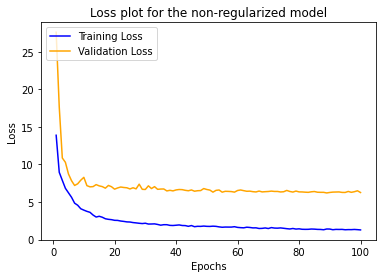

In [12]:
hist = batchnorm_opt_1(non_regularized_model, 1e-5, 1e-4, train_samples, train_labels, val_samples, val_labels)
visualize_experiment(hist)

In [15]:
# Option 1: Using batch normalization at every convolution layer
def batchnorm_opt_2(template_model, reg_ratio, lr, training_samples, training_labels, valid_samples, valid_labels):
    batchnorm_model = template_model.copy()
    batchnorm_model = get_model_with_reg(template_model, reg_ratio)
    for layer in batchnorm_model:
        if layer["type"] in ("dense"):
            layer["batch_norm"] = True
    exp_model = AgeModel(batchnorm_model, "channels_last")
    exp_model.build_comp_graph((None, 91, 91, 1))
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanAbsoluteError()
    exp_model.compile(loss=loss, optimizer=optim)
    history = exp_model.fit(x=training_samples, y=training_labels, epochs=100, verbose=1, validation_data=(valid_samples, valid_labels))
    return history

In [17]:
hist_2 = batchnorm_opt_2(non_regularized_model, 1e-5, 1e-4, train_samples, train_labels, val_samples, val_labels)
visualize_experiment(hist_2)

Epoch 1/100
169/169 [==============================] - 12s 71ms/step - loss: 31.6379 - val_loss: 32.0375
Epoch 2/100
105/169 [=================>............] - ETA: 3s - loss: 31.6479

KeyboardInterrupt: 

In [11]:
def add_dropout(template_model, dropout_ratio, reg_ratio, lr, train_data, val_data):
    model = template_model.copy()
    model = get_model_with_reg(model, reg_ratio)
    layers = []
    for layer_idx in range(len(model)):
        if model[layer_idx]["type"] == "conv2d":
            model[layer_idx]["batch_norm"] = True
        if model[layer_idx]["type"] == "dense" and model[layer_idx]["units"] != 1:
            layers.append({"type": "dropout", "rate": dropout_ratio})
        layers.append(model[layer_idx])
    exp_model = AgeModel(layers, "channels_last")
    exp_model.build_comp_graph((None, 91, 91, 1))
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanAbsoluteError()
    exp_model.compile(loss=loss, optimizer=optim)
    history = exp_model.fit(x=train_data[0], y=train_data[1], epochs=100, verbose=1, validation_data=(val_data[0], val_data[1]))
add_dropout(non_regularized_model, 0.4, 1e-4, 1e-4, (train_samples, train_labels), (val_samples, val_labels))

Epoch 1/100
169/169 [==============================] - 12s 72ms/step - loss: 16.2520 - val_loss: 24.9168
Epoch 2/100
169/169 [==============================] - 12s 70ms/step - loss: 11.8192 - val_loss: 22.5528
Epoch 3/100
169/169 [==============================] - 12s 70ms/step - loss: 10.5024 - val_loss: 15.5610
Epoch 4/100
169/169 [==============================] - 12s 69ms/step - loss: 9.8830 - val_loss: 11.2412
Epoch 5/100
169/169 [==============================] - 12s 69ms/step - loss: 9.2801 - val_loss: 9.3638
Epoch 6/100
169/169 [==============================] - 12s 70ms/step - loss: 8.7252 - val_loss: 12.8042
Epoch 7/100
169/169 [==============================] - 12s 69ms/step - loss: 8.2883 - val_loss: 10.0401
Epoch 8/100
169/169 [==============================] - 12s 70ms/step - loss: 7.9186 - val_loss: 8.7205
Epoch 9/100
169/169 [==============================] - 12s 70ms/step - loss: 7.5268 - val_loss: 8.7166
Epoch 10/100
169/169 [==============================] - 12s 71ms

169/169 [==============================] - 12s 68ms/step - loss: 3.5387 - val_loss: 15.5633
Epoch 80/100
169/169 [==============================] - 12s 68ms/step - loss: 3.4963 - val_loss: 15.7830
Epoch 81/100
169/169 [==============================] - 12s 68ms/step - loss: 3.5110 - val_loss: 16.7589
Epoch 82/100
169/169 [==============================] - 12s 68ms/step - loss: 3.4501 - val_loss: 16.7081
Epoch 83/100
169/169 [==============================] - 12s 69ms/step - loss: 3.5477 - val_loss: 15.4888
Epoch 84/100
169/169 [==============================] - 12s 70ms/step - loss: 3.5002 - val_loss: 15.8474
Epoch 85/100
169/169 [==============================] - 12s 70ms/step - loss: 3.4346 - val_loss: 16.2272
Epoch 86/100
169/169 [==============================] - 12s 70ms/step - loss: 3.4550 - val_loss: 17.7285
Epoch 87/100
169/169 [==============================] - 12s 70ms/step - loss: 3.5147 - val_loss: 16.3480
Epoch 88/100
169/169 [==============================] - 12s 70ms/ste